In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

1


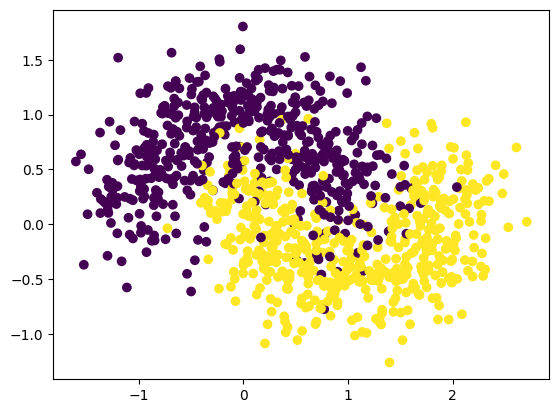

In [ ]:
X, Y = make_moons(n_samples = 1000, noise = 0.3, random_state = 0)
plt.scatter(X[:,0], X[:,1], c=Y)


In [ ]:
import tensorflow as tf

y = tf.keras.utils.to_categorical(Y)

In [ ]:
from keras.layers import Input, Dense, Layer, Dropout
from keras.models import Model


class SamplingSoftmax(Layer):

  def __init__(self, num_samples = 50):
    self.num_samples = num_samples
    super().__init__()

  def call(self,input):
    logit_mean, logit_variance = input

    logit_mean = tf.expand_dims(logit_mean, axis = 1)
    logit_mean = tf.repeat(logit_mean, self.num_samples, axis = 1)

    logit_variance = tf.expand_dims(logit_variance, axis = 1)
    logit_variance = tf.repeat(logit_variance, self.num_samples, axis = 1)

    normal_samples = tf.random.normal(shape = tf.shape(logit_mean))

    gaussian_logits = normal_samples * logit_variance + logit_mean

    softmax_samples = tf.nn.softmax(gaussian_logits)

    return tf.reduce_mean(softmax_samples, axis = 1)


inp_layer = Input(2)

hidden_layer = Dense(units = 10, activation = 'relu')(inp_layer)
hidden_layer = Dropout(rate = 0.2)(hidden_layer)
hidden_layer = Dense(units = 10, activation = 'relu')(hidden_layer)
hidden_layer = Dropout(rate = 0.1)(hidden_layer)

logit_mean  = Dense(units = 2, activation = 'linear')(hidden_layer)
logit_variance  = Dense(units = 2, activation = 'softplus')(hidden_layer)

output_layer = SamplingSoftmax()([logit_mean, logit_variance])

model = Model(inp_layer, output_layer)

model.compile(optimizer ="adam", loss="categorical_crossentropy")

model.fit(X,y, epochs = 150)

Epoch 1/150
32/32 [==============================] - 1s 3ms/step - loss: 0.6388
Epoch 2/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6036
Epoch 3/150
32/32 [==============================] - 0s 2ms/step - loss: 0.5624
Epoch 4/150
32/32 [==============================] - 0s 3ms/step - loss: 0.5056
Epoch 5/150
32/32 [==============================] - 0s 3ms/step - loss: 0.4600
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 0.4306
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 0.4024
Epoch 8/150
32/32 [==============================] - 0s 2ms/step - loss: 0.3885
Epoch 9/150
32/32 [==============================] - 0s 3ms/step - loss: 0.3991
Epoch 10/150
32/32 [==============================] - 0s 2ms/step - loss: 0.4026
Epoch 11/150
32/32 [==============================] - 0s 2ms/step - loss: 0.3811
Epoch 12/150
32/32 [==============================] - 0s 3ms/step - loss: 0.3951
Epoch 13/150
32/32 [=================

1000


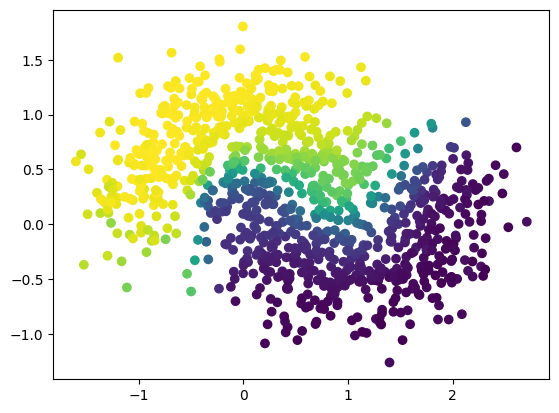

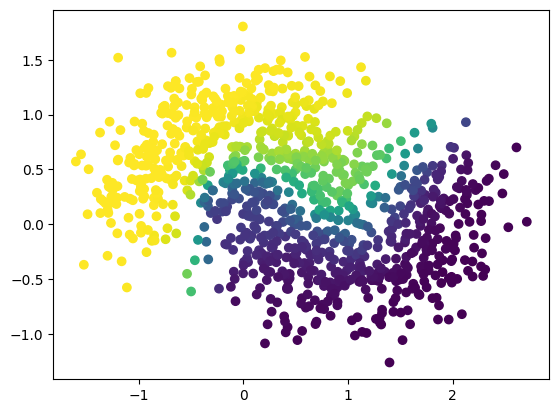

In [ ]:
pred_model = Model(inp_layer, [logit_mean, logit_variance])

all_logit_mean_preds = []
all_logit_variance_preds = []

for i in range(100):
  logit_mean_pred, logit_variance_pred = pred_model(X, training = True)
  all_logit_mean_preds.append(logit_mean_pred)
  all_logit_variance_preds.append(logit_variance_pred)

epi_variance = np.var(all_logit_mean_preds, axis = 0)

ale_variance = np.mean(np.array(all_logit_variance_preds), axis = 0)

logit_means = np.mean(all_logit_mean_preds, axis = 0)

epi_probabilities = SamplingSoftmax(num_samples = 100)([logit_means,epi_variance])
ale_probabilities = SamplingSoftmax(num_samples = 100)([logit_means,ale_variance])

plt.scatter(X[:,0], X[:,1], c=epi_probabilities[:,0])
plt.show()

plt.scatter(X[:,0], X[:,1], c=ale_probabilities[:,0])
plt.show()

In [ ]:
print(input_grid)

[[-2.5977957  -2.26278719]
 [-2.53411107 -2.26278719]
 [-2.47042643 -2.26278719]
 ...
 [ 3.57961361  2.80519037]
 [ 3.64329824  2.80519037]
 [ 3.70698288  2.80519037]]


In [ ]:

def entropy(x):
  return -x * np.log(x)

#--- define new linear space ---------

xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
steps = 100

x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)

input_grid = np.stack([xx.reshape(-1), yy.reshape(-1)], axis = 1)

#---- repeated code with different labels --------------

all_logit_mean_preds = []
all_logit_variance_preds = []

for i in range(100):
  logit_mean_pred, logit_variance_pred = pred_model(input_grid, training = True)
  all_logit_mean_preds.append(logit_mean_pred)
  all_logit_variance_preds.append(logit_variance_pred)

epi_variance = np.var(all_logit_mean_preds, axis = 0)

ale_variance = np.mean(np.array(all_logit_variance_preds), axis = 0)

logit_means = np.mean(all_logit_mean_preds, axis = 0)

epi_probabilities = SamplingSoftmax(num_samples = 100)([logit_means,epi_variance])
ale_probabilities = SamplingSoftmax(num_samples = 100)([logit_means,ale_variance])

10000
10000


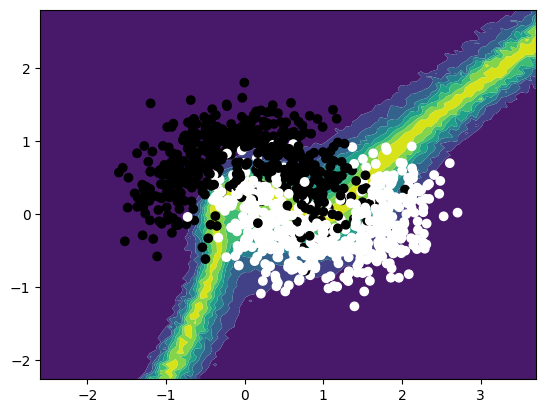

In [ ]:
#aleatoric ------------------------------------------------

#predictions
labels = ale_probabilities[:, 0].numpy()
print(len(labels))

labels = entropy(labels)
print(len(labels))

#decision boundary
z = labels.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx,yy,z, antialiased = True)

plt.scatter(X[:,0], X[:,1], c=y[:,0], cmap='binary')

10000
10000


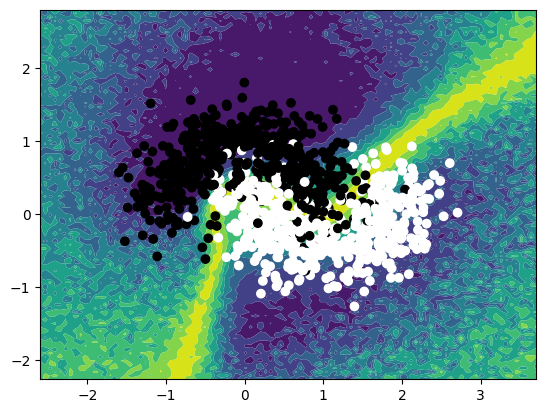

In [ ]:
#epistemic ------------------------------------------------

#predictions
labels = epi_probabilities[:, 0].numpy()
print(len(labels))

labels = entropy(labels)
print(len(labels))

#decision boundary
z = labels.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx,yy,z, antialiased = True)

plt.scatter(X[:,0], X[:,1], c=y[:,0], cmap='binary')